In [34]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['ggplot', 'assets/class.mplstyle'])

red = '#E24A33'
blue = '#348ABD'
purple = '#988ED5'
gray = '#777777'
yellow = '#FBC15E'
green = '#8EBA42'
pink = '#FFB5B8'

---

# Common Statistical Distributions in Astronomy

We have already explored the classical treatment of the gaussian distribution. Let's now look at other probability distributions that arise in typical astronomical calculations.

## 1. The Binomial Distribution

*Counting Problems.*

An experiment has two possible outcomes, generally thought of as *success* or *failure*. Say the probability of success is $\rho$. If you make the experiment $N$ times, what is the chance of getting $n$ *successes*?:

$$ p(n) = {N\choose n} \rho^n (1-\rho)^{N-n} $$

Obviously this distribution takes discrete values. The mean and variance of the RV $n$ is calculated as:

$$ E(n) = \sum_{n=0}^N n p(n) = N \times \rho \\
Var(n) = \sum_{n=0}^N (n-N\rho)^2 p(n) = N \rho (1-\rho)$$

In [53]:
from scipy.stats import binom

np.random.seed(45)

N = 20
rho = .5

binomial_rv = binom(N, rho)

We can look at its moments:

In [54]:
E, V, S, K = binomial_rv.stats(moments='mvsk')
print('E(x)={}, Var(x)={}, Skew(x)={:.3f}, K(x)={:.3f}'.format(E, V, S, K))

E(x)=10.0, Var(x)=5.0, Skew(x)=0.000, K(x)=-0.100


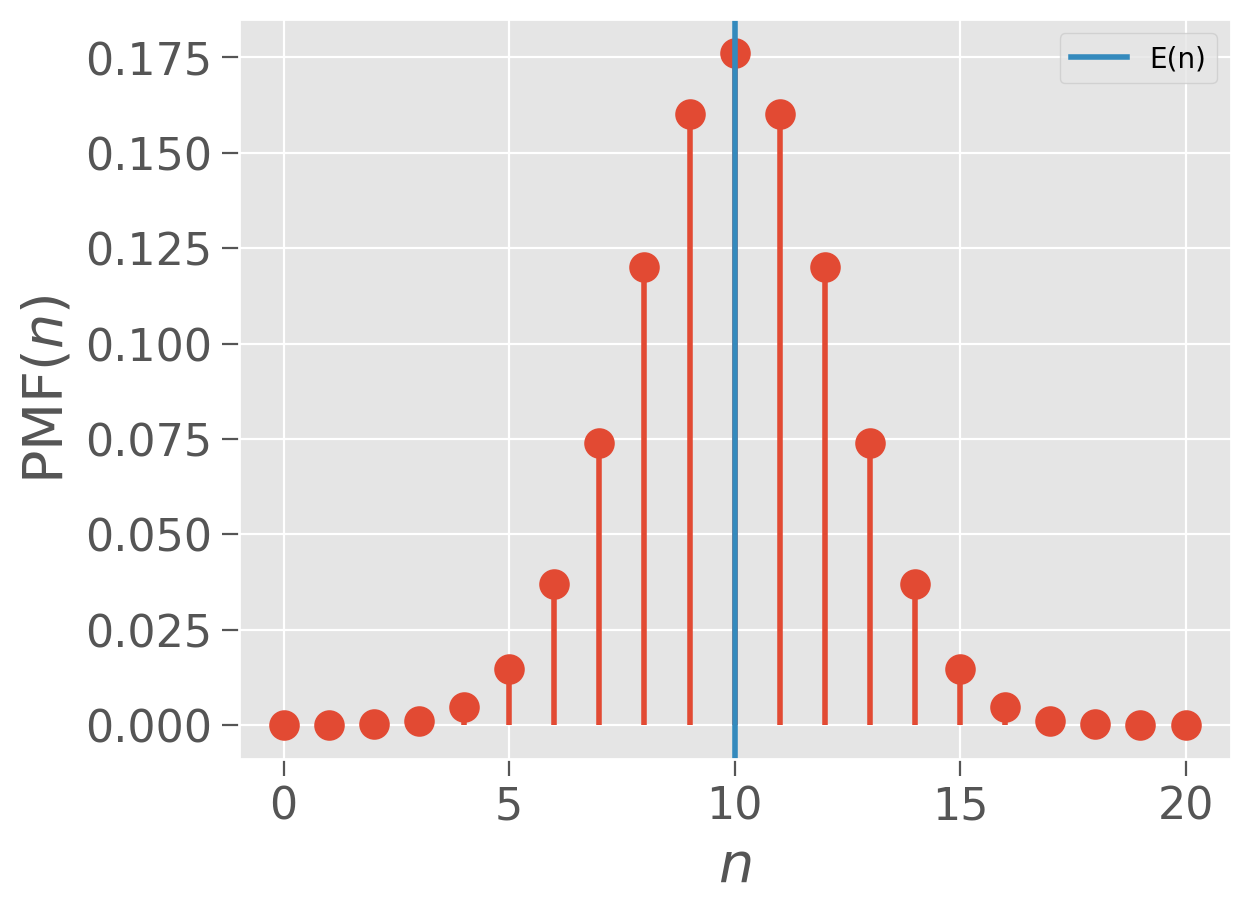

In [55]:
n_to_plot = np.arange(N+1)

plt.plot(n_to_plot, binomial_rv.pmf(n_to_plot), color=red, ls='None', 
         marker='o')
plt.vlines(n_to_plot, binomial_rv.pmf(n_to_plot), 0, color=red)

mean = N * rho
plt.axvline(mean, color=blue, label="E(n)")

plt.xlabel('$n$')
plt.ylabel('PMF($n$)')

_= plt.legend()

---
### Example

We have studied a sample of 60 globular clusters and found that 10 of them have a black hole in their center. We want to know more about black holes in globular clusters so we design a new survey. We will study 20 globular clusters. In our proposal we must place a constrain on the number of new Black Holes we expect to find. For example, what is the chance we will find 10 or more BHs among our 20 GCs?

### Solution

If we assume that our original sample is representative, then we can say that $\rho=10/60$. With that, we can calculate the PMF.

In [56]:
N = 20
rho = 10 / 60

bh_rv = binom(N, rho)

Text(0, 0.5, 'BH PMF($n$)')

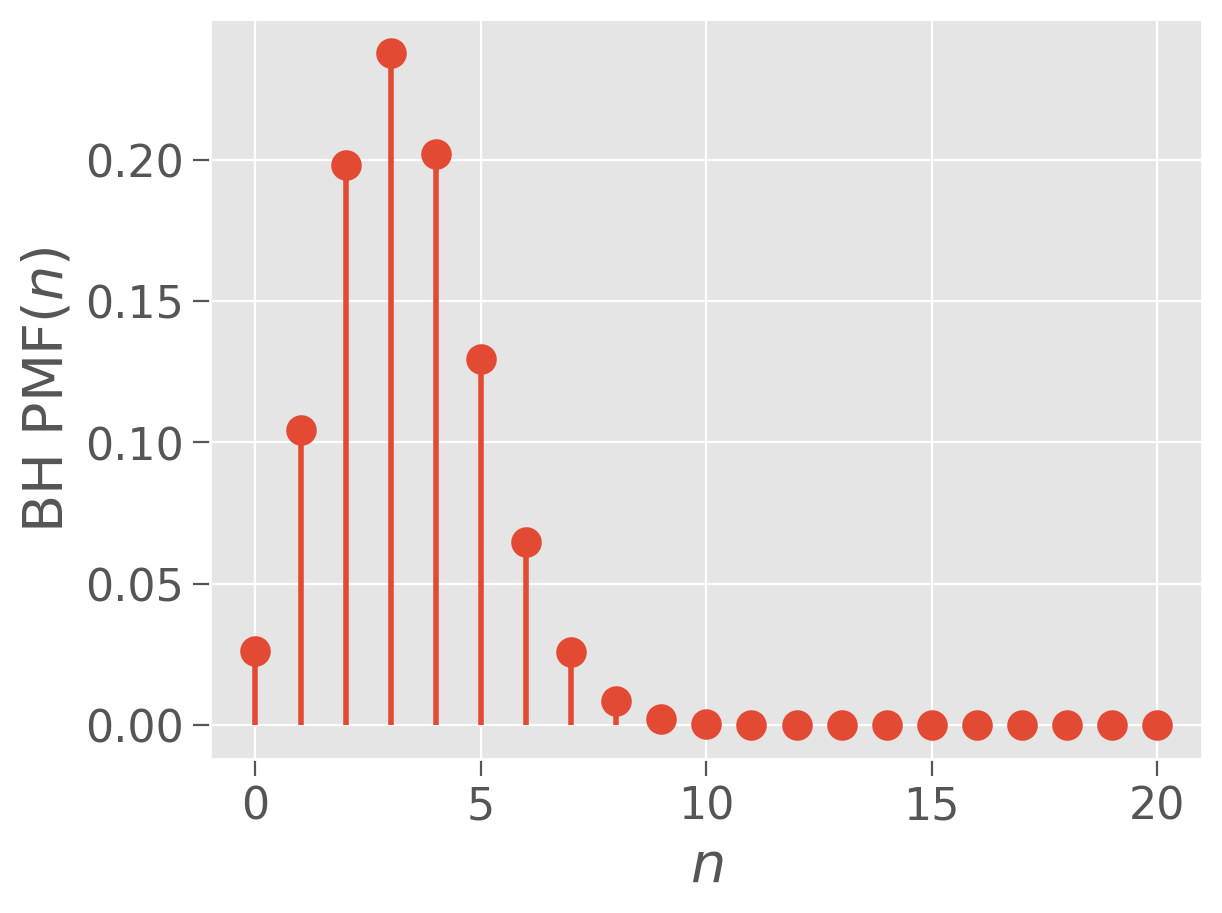

In [57]:
n_to_plot = np.arange(N+1)

plt.plot(n_to_plot, bh_rv.pmf(n_to_plot), color=red, ls='None', 
         marker='o')
plt.vlines(n_to_plot, bh_rv.pmf(n_to_plot), 0, color=red)

plt.xlabel('$n$')
plt.ylabel('BH PMF($n$)')

In [61]:
np.sum(bh_rv.pmf([10,11]))

0.0005832090491853172

In [63]:
chance_of_10_to_20 = bh_rv.pmf(range(10, 21))
chance_of_10plus = np.sum(chance_of_10_to_20)

print("The chance of finding 10 BHs among 20 GCs is: {:.3f}%".format(100*chance_of_10plus))

The chance of finding 10 BHs among 20 GCs is: 0.060%


Notice that we started by estimating $\rho = \bar{\rho} =10/60$. This is reasonable for the Binomial Distribution but what about the confidence for this value? Let's see how the Bootstrap behaves here.

This is what we will do:

- Start by assuming the parent $\rho = 1/6$, and make many samples from the binomial.
- For each sample, come up with an estimate of $\bar{\rho}$
- Make a histogram of $\bar{\rho} - \rho$

This is the reference for the distribution of $\bar{\rho} - \rho$. Now to the Bootstrap:

- Make a reference sample with 10 Trues (represented by 1), and 50 Falses (represented by 0)
- Make samples with replacement out of that sample
- Each time, estimate $\rho^*$
- Make a histogram of $\rho^*-\bar{\rho}$

In [64]:
# The reference sample with assumed known rho

rho = 10/60
N_sample = 60

N_mc = 100000

survey_rv = binom(N_sample, rho)
rho_mc = survey_rv.rvs(size=N_mc) / N_sample

x_mc, n_mc = np.unique(rho_mc - rho, return_counts=True)

In [67]:
# The Bootstrap

survey_sample = np.zeros(N_sample)
survey_sample[:10] = 1.
print("Total number of BHs in the sample: {}".format(np.sum(survey_sample)))

Total number of BHs in the sample: 10.0


In [69]:
np.sum(survey_sample)

10.0

In [70]:
N_boot = 100000

indices = np.random.randint(0, high=N_sample, size=(N_sample, N_boot))
bootstrap_means = survey_sample[indices].sum(axis=0) / N_sample

x_boot, n_boot = np.unique(bootstrap_means - rho, return_counts=True)

In [80]:
np.unique(survey_sample[indices].sum(axis=0), return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 array([   17,   137,   484,  1399,  3076,  5838,  8799, 11655, 13492,
        13576, 12521, 10146,  7497,  4955,  3116,  1716,   832,   423,
          192,    88,    28,    10,     2,     1]))

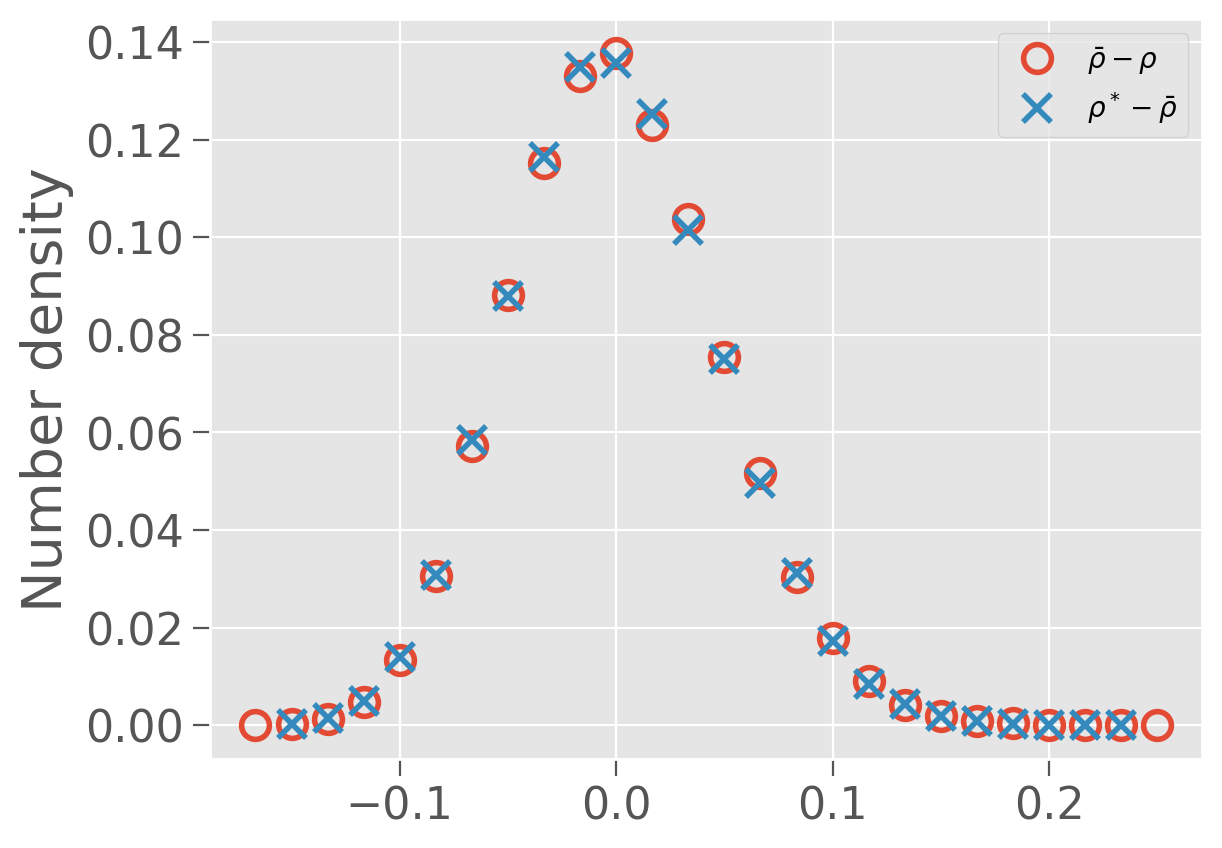

In [81]:
plt.plot(x_mc, n_mc/N_mc, marker='o', ls='None', mec=red, mfc='None', mew=2.,
         label=r'$\bar{\rho}-\rho$')
plt.plot(x_boot, n_boot/N_boot, marker='x', ls='None', color=blue, mew=2.,
        label=r'$\rho^*-\bar{\rho}$')

plt.ylabel('Number density')
_= plt.legend()

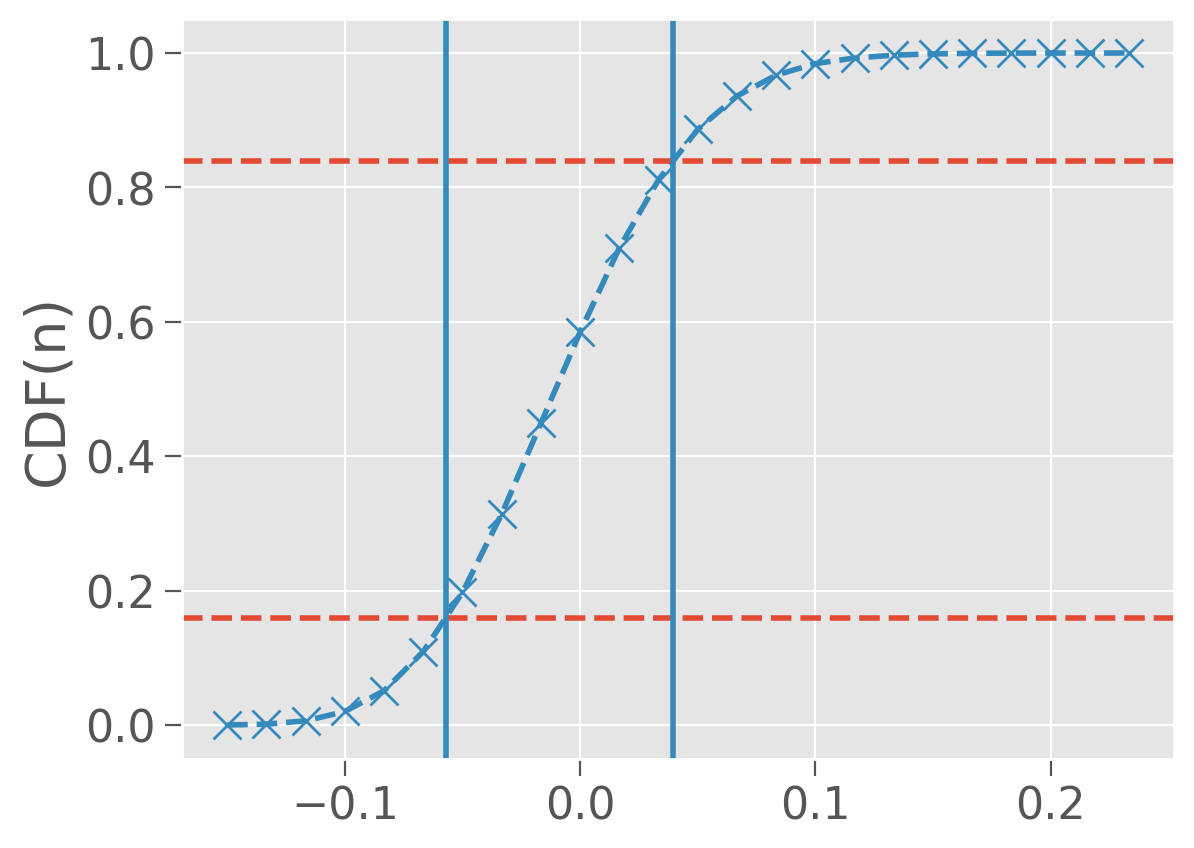

In [82]:
plt.plot(x_boot, np.cumsum(n_boot) / N_boot, 'x--', color=blue)

# Let's explore the 68% C.I.
plt.axhline(0.16, ls='--', color=red)
plt.axhline(0.84, ls='--', color=red)

# An approximation to the Point Percentile Function
ci_lo68, ci_hi68 = np.interp([0.16, 0.84], np.cumsum(n_boot)/N_boot, x_boot)
plt.axvline(ci_lo68, color=blue)
plt.axvline(ci_hi68, color=blue)

plt.ylabel('CDF(n)');

In [83]:
print(ci_lo68, ci_hi68)

-0.05710307989544265 0.03969143212840693


In [84]:
print('The 68% CI for rho is: [{:.2f}:{:.2f}]'.format(1/6-ci_hi68, 1/6-ci_lo68))

The 68% CI for rho is: [0.13:0.22]


---

---

## 2. The Poisson Distribuition

*Photons in a detector.*

In the limiting case of a Binomial Distribution, when $\rho\to0$ (very small chance) but $E(n)=(N\times\rho)\to \mu$, some finite value, the expression for the Binomial Distribution PMF approaches the expression:

$$ p(n) = \frac{\mu^n}{n!}e^{-\mu} $$

which is the PMF for the Poisson Distribution. The mean and variance of the Possion distribution are both $\mu$:

$$ E(n) = Var(n) = \mu $$



The classical Astronomical context is that of the photon arrival from a given source. For example, an AGN emits a very large number of X-ray photons but only a small number of them arrives in our detector in a given span of time. So, the probability of detecting any given photon is very small (that is $\rho$ is small for the Binomial), but the mean ($N\times\rho$) is not small because of the huge number of photons emitted by the AGN.

In [85]:
from scipy.stats import poisson

mu = 2.
poisson_rv = poisson(mu)

In [87]:
E, V, S, K = poisson_rv.stats(moments='mvsk')
print('E(x)={}, Var(x)={}, Skew(x)={:.3f}, K(x)={:.3f}'.format(E, V, S, K))

E(x)=2.0, Var(x)=2.0, Skew(x)=0.707, K(x)=0.500


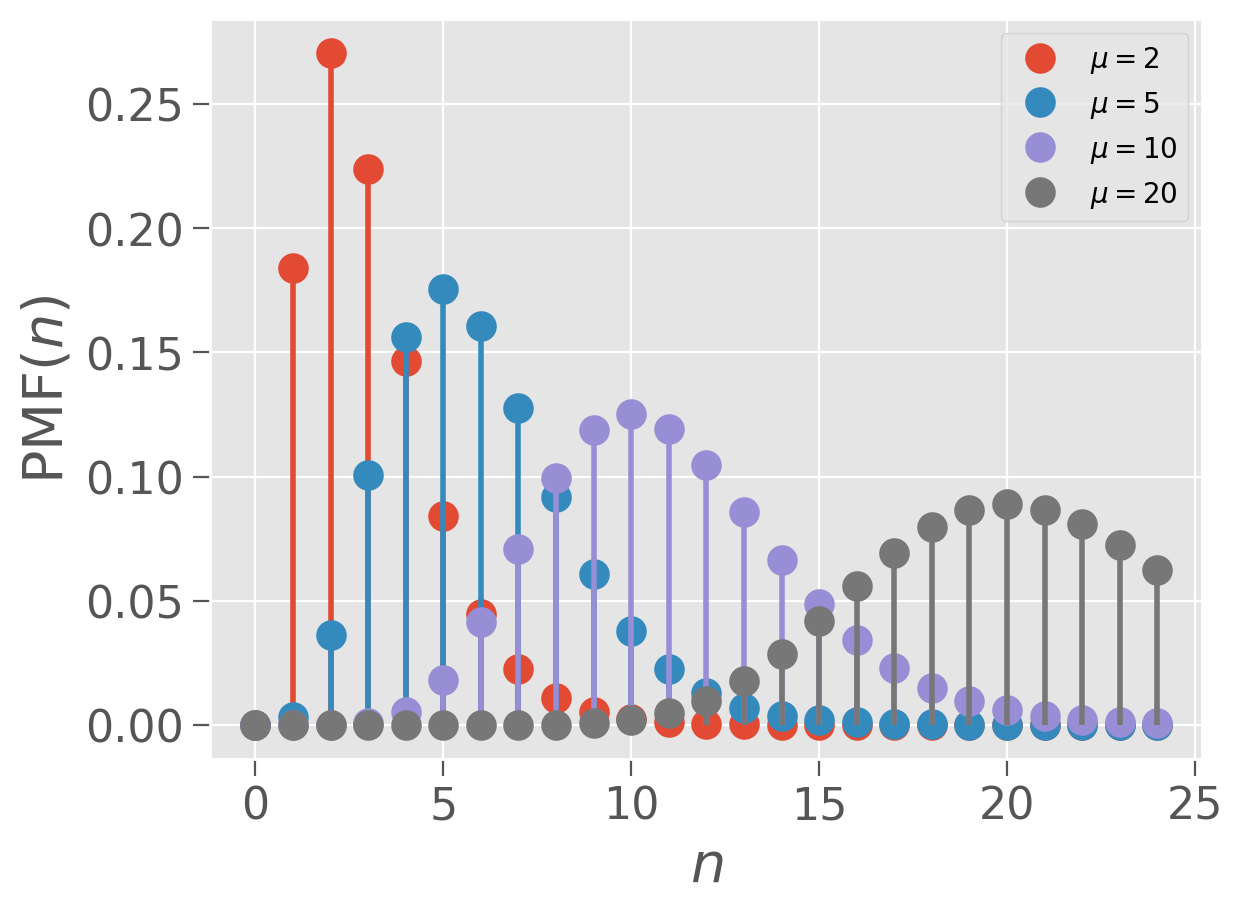

In [90]:
N_max = 25
n_to_plot = np.arange(N_max)

mu_values = [2, 5, 10,20]

for mu in mu_values:
    _ = plt.plot(n_to_plot, poisson.pmf(mu, n_to_plot), ls='None', 
                 marker='o', label='$\mu={}$'.format(mu))
    plt.vlines(n_to_plot, poisson.pmf(mu, n_to_plot), 0, color=_[0].get_color())

plt.xlabel('$n$')
plt.ylabel('PMF($n$)')

_= plt.legend()

---
### Example

Suppose the photons from a source arrive at our detector at an average rate $\lambda$ (photons per unit time). Determine how does the Signal to Noise ratio (S/N) behave with integration time $t$

### Solution

**Case 1) We only get the source photons.**

The Signal is the mean flux we get in a time interval $t$. That will be $\mu=\lambda t$, the mean of the Poisson distribution. The noise, is the standar deviation on that RV, $\sigma=\sqrt{\mu}=\sqrt{\lambda t}$. Combining both:

$$ S/N \propto \sqrt{\lambda t} $$

**Case 2) We get photons from the source but the background photons from the sky dominate**

The Signal stays the same, but now we also get photons from another source that contribute to the Noise. Now $\sigma=\sqrt{\mu + \mu_{sky}}\sim\sqrt{\lambda_{sky} t}$.

$$ S/N \propto \frac{\lambda}{\sqrt{\lambda_{sky}}}\sqrt{t} $$


There are other cases of interest that we will explore further when talking about astronomical data. You can also skim "Practical Statistics for Astronomers", Ch. 2.4.2.2.

---

---

## 3. The Pareto (power-law) Distribuition.



Power laws are everywhere in astronomy. The PDF of a Pareto distribution takes the form:

$$ p(x) =  \frac{b}{s} \left(\frac{s}{x-l}\right) ^{b+1}$$

$x\geq s+l, b>0$. Where $s$ is called the scale and $l$ the location.

As an example, let's take a sample of stellar masses from the Salpeter (1955) initial mass function (IMF).

The Salpeter IMF is the number density distribution of stellar masses of a newly minted stellar population, it has a slope $\alpha=-2.35$.

In [91]:
from scipy.stats import pareto

b = 1.35
min_mass = 0.08 # solar masses, less than that and you cannot have fusion

pareto_rv = pareto(b, loc=0, scale=min_mass)
M_sample = pareto_rv.rvs(size=1000)

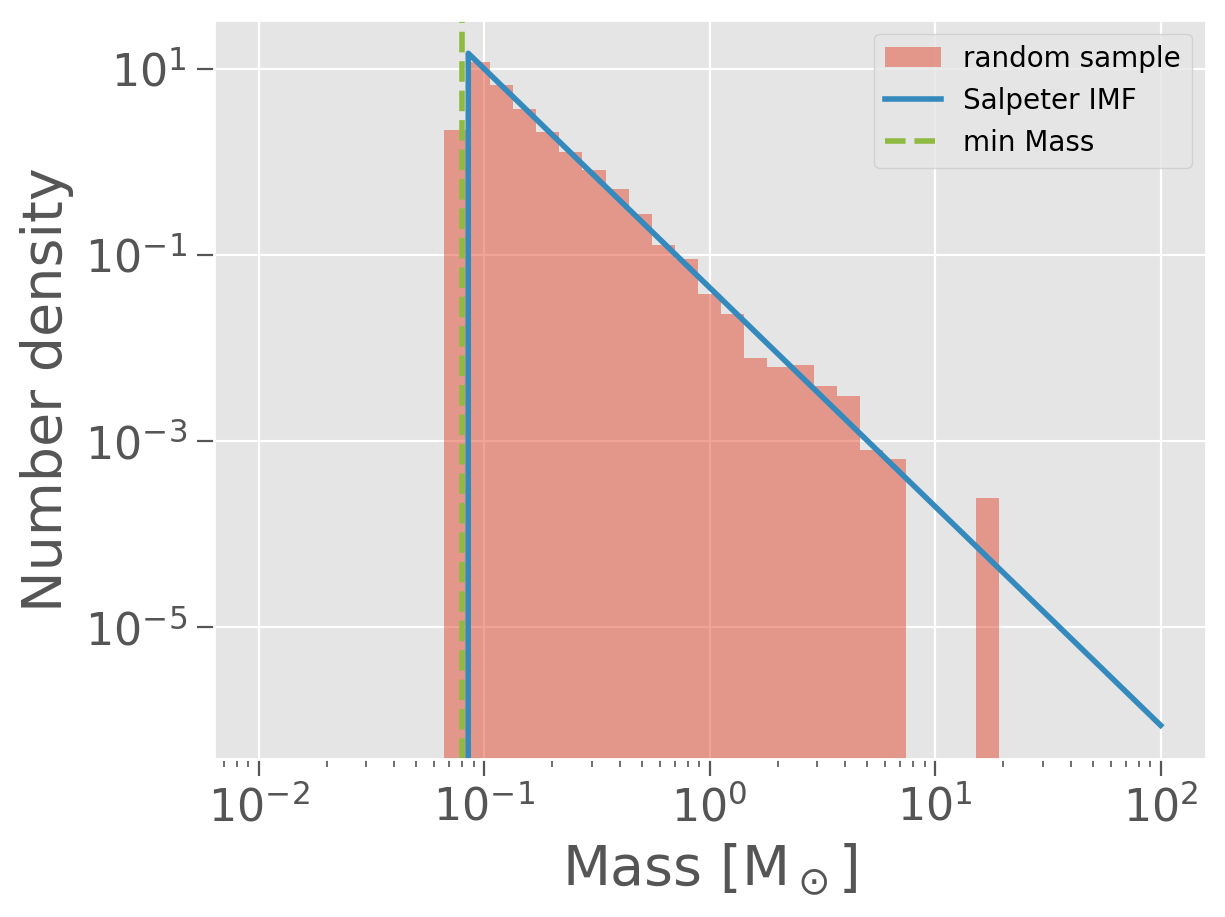

In [97]:
M_to_plot = np.logspace(-2, 2, 100)

plt.hist(M_sample, density=True, bins=np.logspace(-2, 2, 40), alpha=0.5,
         label='random sample')

# plt.plot(M_to_plot, b / M_to_plot**(b+1) * 0.08**b, color=red)
plt.plot(M_to_plot, pareto_rv.pdf(M_to_plot), color=blue, label='Salpeter IMF')

plt.axvline(min_mass, ls='--', color=green, label='min Mass')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Mass [M$_\odot$]')
plt.ylabel('Number density')
_= plt.legend()

There are many more distributions that are relevant to Astronomy. The recommended course bibliography covers several more.

---

## 4. The Central Limit Theorem.

Crude intuitive (useful) version (from "Practical Statistics for Astronomers" Ch. 2.4.2.3):

> If you make averages $M_n$ from repeatedly drawing $n$ samples **from a RV with finite mean $\mu$ and variance $\sigma^2$**, then for large $n$, the distribution of: 

$$ \left[ \frac{(M_n-\mu)}{\sigma/\sqrt{n}} \right] \to \mathcal{N}(0, 1) $$

Let's reproduce the example from "Practical Statistics for Astronomers" Ch. 2.4.2.3. We will consider an exponential distribution: $pdf(x)\propto e^{-x}$, $x\geq0$.

In [99]:
from scipy.stats import expon

exp_rv = expon()

N_sample = 200
sample = exp_rv.rvs(size=200)

E, V, S, K = expon.stats(moments='mvsk')
print('E(x)={}, Var(x)={}, Sigma(x)={}, K(x)={}'.format(E, V, S, K))

E(x)=1.0, Var(x)=1.0, Sigma(x)=2.0, K(x)=6.0


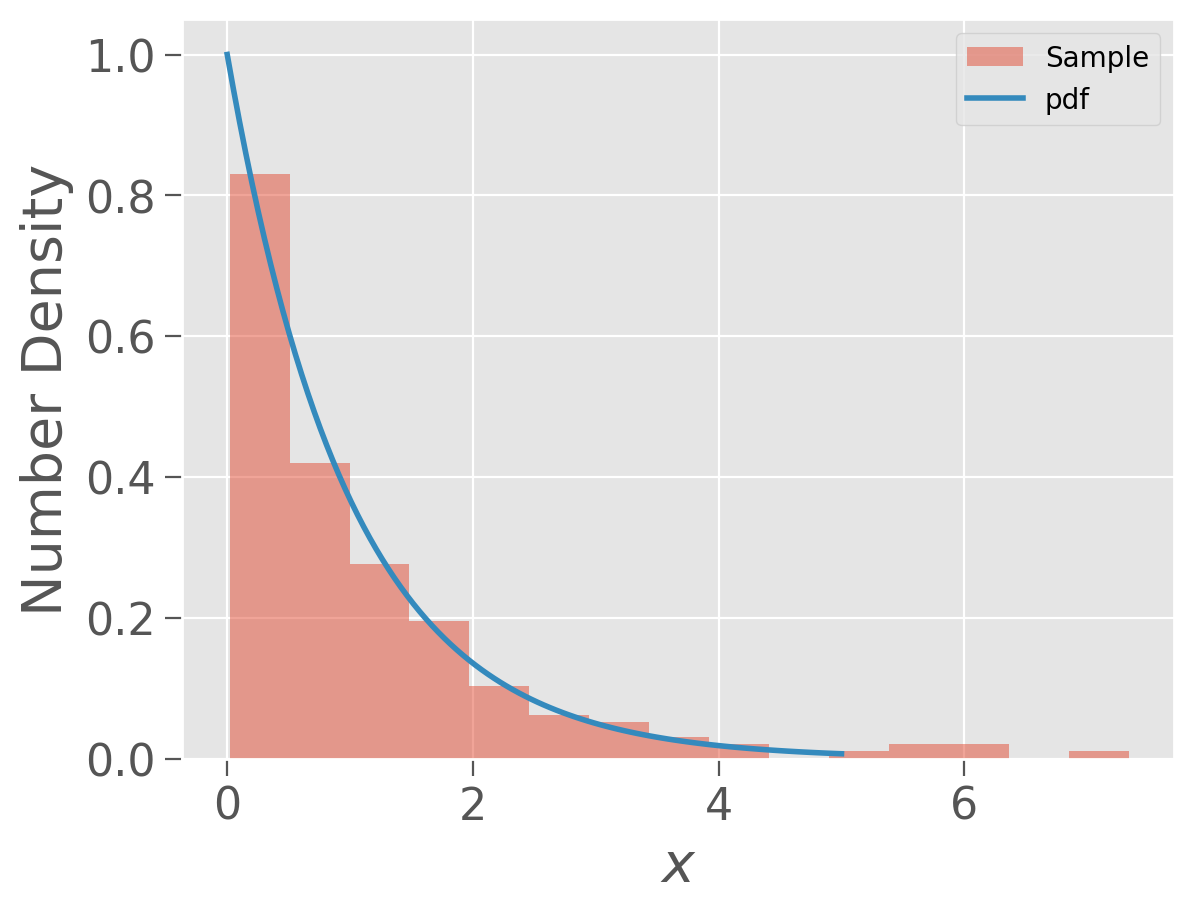

In [101]:
plt.hist(sample, bins=15, density=True, alpha=0.5, label='Sample')

x_to_plot = np.linspace(0, 5, 100)
plt.plot(x_to_plot, np.exp(-x_to_plot), label='pdf')

plt.xlabel('$x$')
plt.ylabel('Number Density')

_= plt.legend()

We see that a sample of 200 values follows the exponential closely.

Now, we will draw 20 values from the exponential and take their mean. We will repeat 200 times and look at the histogram of these $M_{20}$ averages.

In [103]:
sample = expon.rvs(size=(20, 200))
m_20 = sample.mean(axis=0)

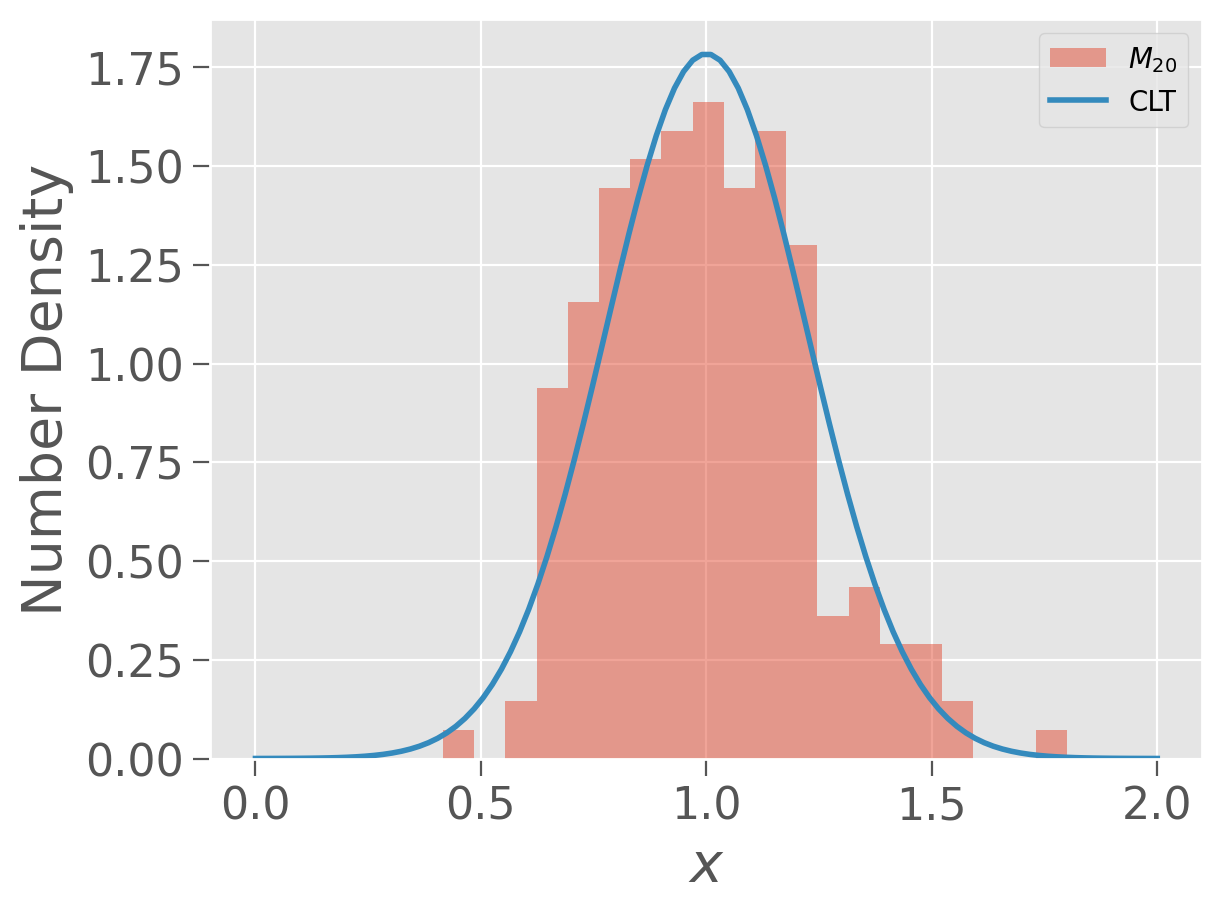

In [105]:
from scipy.stats import norm

plt.hist(m_20, bins=20, density=True, alpha=0.5, label='$M_{20}$')

# Estimate of the distribution from the CLT
x_to_plot = np.linspace(0, 2, 100)
plt.plot(x_to_plot, norm.pdf(x_to_plot, loc=E, scale=np.sqrt(V)/np.sqrt(20)),
         label='CLT')

plt.xlabel('$x$')
plt.ylabel('Number Density')

_= plt.legend()

The example above shows that even for parent distributions that are far from a gaussian, averages of large samples will distribute as a gaussian.

The big deal here is that there is this theorem ensuring that, if we want to estimate some mean quantity from a population, we get improved accuracy as the sample size increases ($\propto \sqrt{N}$). 